# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4290.357627,0.9999,-131.886217,2105.42,1973.533783
OMUSDT,526.319895,1861.823834,0.4340,0.000000,1335.50,1335.500000
BTCUSDT,601.021649,884.865404,0.2062,3.537078,283.84,287.377078
JASMYUSDT,387.458505,627.235976,0.1462,0.000000,239.78,239.780000
SOLUSDT,281.200518,428.363512,0.0998,0.000000,147.16,147.160000
ETHUSDT,250.747339,277.276757,0.0646,0.000000,26.53,26.530000
TRXUSDT,76.868953,155.906738,0.0363,-10.723889,79.04,68.316111
BBUSDT,60.176053,53.607816,0.0125,-39.733101,-6.57,-46.303101
BNBUSDT,1.142121,1.277585,0.0003,-10.606040,0.14,-10.466040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-02    1418.524583
2024-12-03    1806.096259
2024-12-04    1729.714053
2024-12-05    1990.847138
2024-12-06    1981.149715
Name: Total, Length: 75, dtype: float64

In [24]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

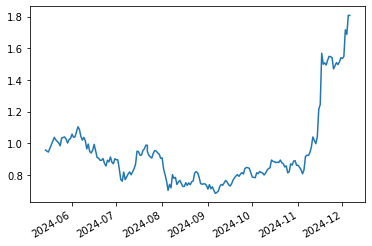

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3391
BNBUSDT,0.1666
TRXUSDT,0.1260
PEPEUSDT,0.1033
XRPUSDT,0.0862
XLMUSDT,0.0701
SUIUSDT,0.0694
JASMYUSDT,0.0392
BONKUSDT,0.0000
DYDXUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.326521
BTCUSDT,0.300000
TRXUSDT,0.113118
PEPEUSDT,0.071270
XLMUSDT,0.057353
SUIUSDT,0.048999
XRPUSDT,0.033040
JASMYUSDT,0.030038
BNBUSDT,0.019662


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.351804
OMUSDT,0.334657
TRXUSDT,0.261974
PEPEUSDT,0.043289
JASMYUSDT,0.008276


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1861.823834,0.433955,0.334657,0.099298
BTCUSDT,884.865404,0.206245,0.351804,-0.145559
JASMYUSDT,627.235976,0.146197,0.008276,0.137921
SOLUSDT,428.363512,0.099843,0.000000,0.000000
ETHUSDT,277.276757,0.064628,0.000000,0.000000
TRXUSDT,155.906738,0.036339,0.261974,-0.225635
BBUSDT,53.607816,0.012495,0.000000,0.000000
BNBUSDT,1.277585,0.000298,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.043289,-0.043289


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1861.823834,0.433955,0.326521,0.107434
BTCUSDT,884.865404,0.206245,0.300000,-0.093755
JASMYUSDT,627.235976,0.146197,0.030038,0.116159
SOLUSDT,428.363512,0.099843,0.000000,0.000000
ETHUSDT,277.276757,0.064628,0.000000,0.000000
TRXUSDT,155.906738,0.036339,0.113118,-0.076779
BBUSDT,53.607816,0.012495,0.000000,0.000000
BNBUSDT,1.277585,0.000298,0.019662,-0.019364
PEPEUSDT,0.000006,0.000000,0.071270,-0.071270
XLMUSDT,0.000000,0.000000,0.057353,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

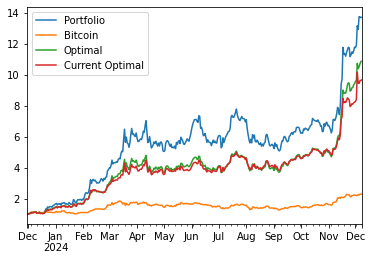

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

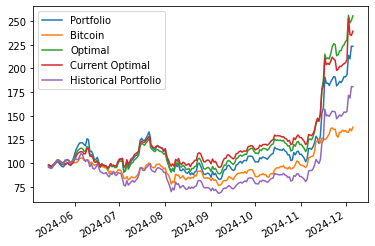

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-27,186.430550,132.783198,218.497657,202.251053,150.943684
2024-11-28,185.039275,132.479326,218.800268,201.953891,149.674755
2024-11-29,187.539507,134.971167,223.281789,203.862941,151.414174
2024-11-30,191.476491,133.506331,224.901382,205.064929,154.042164
2024-12-01,191.077542,134.578273,228.326664,206.046069,153.524639
2024-12-02,193.393646,132.703379,230.233747,209.482532,154.867822
2024-12-03,213.872173,132.715937,256.134816,253.063048,171.684779
2024-12-04,210.188887,136.453406,248.091191,235.792380,168.792541
2024-12-05,223.469147,134.162033,250.787454,234.972355,180.882889
2024-12-06,223.334482,137.975577,255.516402,239.316295,180.754476


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.584087
 dtype: float64,
 0.5848405760962134)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.63523
 dtype: float64,
 0.6352300399590077)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.705049
Bitcoin            0.434779
Optimal            0.584841
Current Optimal    0.576246
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4588418822913971

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.035171,0.019662,0.002740,0.007767,0.000257,0.007510
BTCUSDT,0.391252,0.300000,0.034537,0.150143,0.049740,0.100403
JASMYUSDT,0.095780,0.030038,0.006286,0.024390,0.003285,0.021104
OMUSDT,17.569065,0.326521,0.894112,0.616901,0.508789,0.108112
PEPEUSDT,0.458170,0.071270,0.026452,0.080643,0.023964,0.056680
SUIUSDT,0.136063,0.048999,0.009246,0.033935,0.006361,0.027574
TRXUSDT,0.152429,0.113118,0.013267,0.042065,0.017093,0.024972
XLMUSDT,0.105667,0.057353,0.008145,0.027831,0.005573,0.022257
XRPUSDT,0.071331,0.033040,0.005215,0.016324,0.001353,0.014972


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.909414,0.334657,0.525169,0.559634,0.440862,0.118772
BTCUSDT,0.169564,0.351804,0.220089,0.156821,0.073613,0.083207
JASMYUSDT,0.005769,0.008276,0.005929,0.007834,0.000278,0.007556
TRXUSDT,0.259346,0.261974,0.220069,0.236930,0.180623,0.056308
PEPEUSDT,0.024803,0.043289,0.028744,0.038781,0.007957,0.030824


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.168504,0.43,0.650223,0.637387,0.513668,0.123719
BTCUSDT,0.101217,0.21,0.126594,0.084943,0.018511,0.066432
JASMYUSDT,0.104555,0.15,0.103545,0.154721,0.064385,0.090336
SOLUSDT,0.036980,0.10,0.055719,0.070542,0.010138,0.060404
ETHUSDT,0.012127,0.06,0.029339,0.027722,0.002635,0.025086
TRXUSDT,0.039599,0.04,0.032378,0.014425,0.002972,0.011453
BBUSDT,-0.004590,0.01,0.002201,0.010261,0.000393,0.009868


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.0477585893673752, -0.06837288655121666)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048035312236236284, -0.06776836918524114)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.031897
BTCUSDT     -0.001960
JASMYUSDT   -0.008330
SOLUSDT     -0.003077
ETHUSDT     -0.001657
TRXUSDT     -0.000573
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048740
Name: 2024-07-22 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.038108
BTCUSDT     -0.007166
JASMYUSDT   -0.012251
SOLUSDT     -0.006599
ETHUSDT     -0.002236
TRXUSDT     -0.000657
BBUSDT      -0.000752
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067768
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.060598863969642904, -0.07767098895112225)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06582002062485824, -0.08436306821324276)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.052807545616564415, -0.06916032307791216)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06024020508798023, -0.07670373617043552)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.040929
BTCUSDT     -0.005267
JASMYUSDT   -0.006963
SOLUSDT     -0.003939
ETHUSDT     -0.002052
TRXUSDT     -0.000403
BBUSDT      -0.000723
Portfolio   -0.060277
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05254768806252219, -0.06883581798676296)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05970908476983767, -0.07660324650981312)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.041573
BTCUSDT     -0.004503
JASMYUSDT   -0.007849
SOLUSDT     -0.003862
ETHUSDT     -0.001528
TRXUSDT     -0.000705
BBUSDT      -0.000601
Portfolio   -0.060621
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05316811122779882, -0.0688320695727076)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061737531567121876, -0.07986188168567486)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.040691
BTCUSDT     -0.005447
JASMYUSDT   -0.008893
SOLUSDT     -0.004128
ETHUSDT     -0.001497
TRXUSDT     -0.000544
BBUSDT      -0.000603
Portfolio   -0.061803
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.09488202348114573, -0.1338634851433328)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10665524794478146, -0.14879524937990254)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.098547
BTCUSDT     -0.002103
JASMYUSDT   -0.005476
SOLUSDT     -0.000105
ETHUSDT     -0.000011
TRXUSDT     -0.000730
BBUSDT       0.000267
Portfolio   -0.106705
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06298989536079226, -0.07809279839745352)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06881740952780699, -0.08462027035663294)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.043297
BTCUSDT     -0.005925
JASMYUSDT   -0.009958
SOLUSDT     -0.004664
ETHUSDT     -0.001962
TRXUSDT     -0.000750
BBUSDT      -0.000823
Portfolio   -0.067380
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.051079,-0.084645,-0.073048,-0.024854
2024-01-15,-0.051079,-0.084644,-0.074284,0.013864
2024-01-16,-0.051079,-0.084407,-0.071820,0.038184
2024-01-17,-0.051079,-0.085884,-0.071001,-0.024587
2024-01-18,-0.051079,-0.088324,-0.074803,-0.036044
...,...,...,...,...
2024-12-04,-0.046287,-0.112731,-0.085302,-0.031404
2024-12-05,-0.046287,-0.112960,-0.084777,0.010868
2024-12-06,-0.046287,-0.110163,-0.087542,0.018856
2024-12-07,-0.046287,-0.109964,-0.085321,0.012656


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034747,-0.084721,-0.080125,-0.017896
2024-05-29,-0.034747,-0.082047,-0.076470,-0.008623
2024-05-30,-0.034747,-0.072415,-0.067110,0.041564
2024-05-31,-0.034747,-0.073492,-0.065828,0.039579
2024-06-01,-0.034747,-0.076997,-0.065997,0.052811
...,...,...,...,...
2024-12-04,-0.044527,-0.075985,-0.066827,-0.017222
2024-12-05,-0.044527,-0.080874,-0.068563,0.063183
2024-12-06,-0.044527,-0.081222,-0.070094,-0.000603
2024-12-07,-0.044527,-0.081842,-0.071464,-0.004186


<AxesSubplot:>

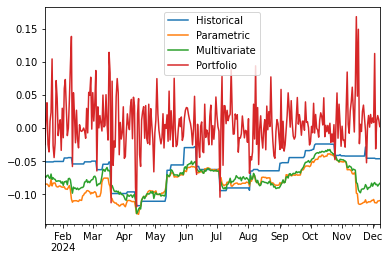

In [80]:
var_data.plot()

<AxesSubplot:>

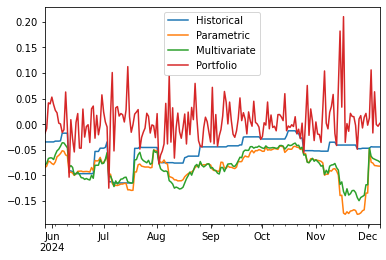

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024242,0.012121,0.012121
Kupiec Stat,5.645706,14.155382,14.155382
P-value,0.017498,0.000168,0.000168


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.061538,0.015385,0.015385
Kupiec Stat,0.510784,6.671087,6.671087
P-value,0.4748,0.009799,0.009799


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77095382, 0.07693877, 0.056028  , 0.05568917, 0.04039024])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015178
ADAUSDT     0.015218
ALGOUSDT    0.017295
APTUSDT     0.015848
ARBUSDT     0.016737
              ...   
WBTCUSDT    0.009619
WLDUSDT     0.021863
XLMUSDT     0.012104
XRPUSDT     0.010576
XTZUSDT     0.016054
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

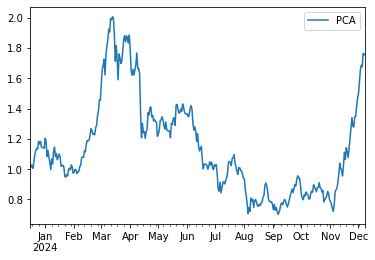

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

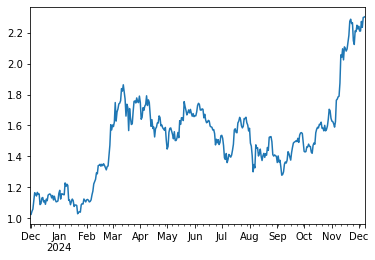

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.406984
WBETHUSDT    0.415751
ETHUSDT      0.415952
EGLDUSDT     0.418309
               ...   
FLOKIUSDT    1.114999
BONKUSDT     1.126194
WLDUSDT      1.127458
PEPEUSDT     1.162357
OMUSDT       1.525793
Length: 64, dtype: float64

<AxesSubplot:>

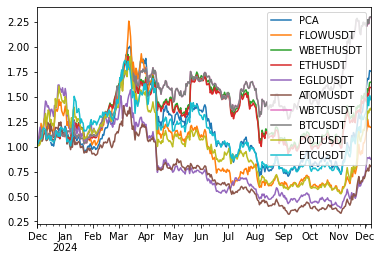

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

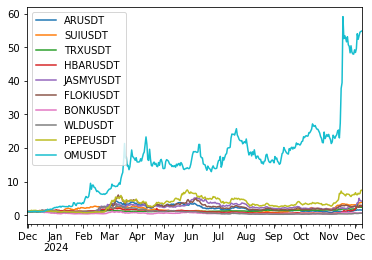

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.5266448 , 0.15215128, 0.13661354, 0.10536006, 0.07923031])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.101445
BTCUSDT      0.062917
JASMYUSDT    0.165077
SOLUSDT      0.102873
ETHUSDT      0.083654
TRXUSDT      0.040518
BBUSDT       0.212698
BNBUSDT      0.067126
PEPEUSDT     0.163692
Name: PC1, dtype: float64

<AxesSubplot:>

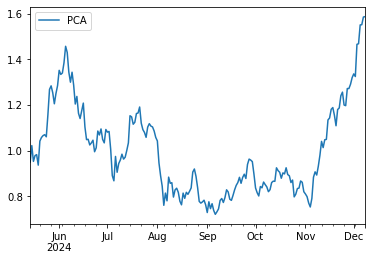

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

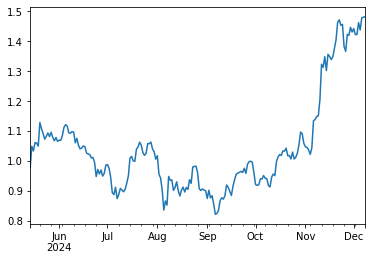

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.380718
ETHUSDT      0.399729
BNBUSDT      0.408975
BTCUSDT      0.414931
JASMYUSDT    0.640606
PEPEUSDT     0.680458
BBUSDT       0.705720
OMUSDT       0.863751
TRXUSDT      0.881678
dtype: float64

<AxesSubplot:>

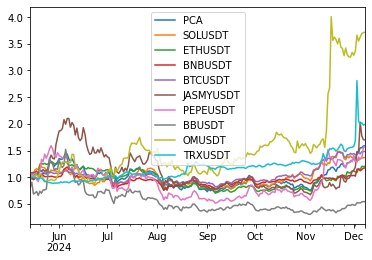

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.905853
BBUSDT       1.515492
JASMYUSDT    1.213007
SOLUSDT      1.139631
BTCUSDT      1.000000
ETHUSDT      0.950047
OMUSDT       0.872205
BNBUSDT      0.653311
TRXUSDT      0.236993
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.744056
BTCUSDT      1.000000
ETHUSDT      0.940708
SOLUSDT      0.933897
BNBUSDT      0.788359
BBUSDT       0.580251
OMUSDT      -0.236372
TRXUSDT     -0.510349
JASMYUSDT   -0.554591
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table

,Beta
OMUSDT,0.075379
BTCUSDT,0.799823
JASMYUSDT,0.137182
SOLUSDT,-0.468943
ETHUSDT,0.258181
TRXUSDT,0.038137
BBUSDT,0.343527
BNBUSDT,-0.067238
PEPEUSDT,-0.010037


In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.24664180980340988

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.210909
BTCUSDT      1.205134
JASMYUSDT    0.386723
SOLUSDT      0.755234
ETHUSDT      0.920192
TRXUSDT      0.145477
BBUSDT       0.329658
BNBUSDT      1.059068
PEPEUSDT     0.362647
PCA          1.000000
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.241441
BTCUSDT      0.878851
JASMYUSDT    0.033390
SOLUSDT      0.440605
ETHUSDT      0.269500
TRXUSDT      0.056118
BBUSDT       0.365589
BNBUSDT      0.413509
PEPEUSDT     0.043299
PCA          1.000000
dtype: float64

In [104]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.296819,0.155682,0.353918,0.227215,0.131068,0.267897,0.206574,0.168687
BTCUSDT,0.296819,1.000000,0.472576,0.703923,0.789990,0.152438,0.553044,0.595699,0.652302
JASMYUSDT,0.155682,0.472576,1.000000,0.455288,0.460712,0.234337,0.542665,0.438989,0.368489
SOLUSDT,0.353918,0.703923,0.455288,1.000000,0.652565,0.175370,0.547156,0.508522,0.540527
ETHUSDT,0.227215,0.789990,0.460712,0.652565,1.000000,0.124965,0.601027,0.583960,0.639510
TRXUSDT,0.131068,0.152438,0.234337,0.175370,0.124965,1.000000,0.131258,0.297331,0.095142
BBUSDT,0.267897,0.553044,0.542665,0.547156,0.601027,0.131258,1.000000,0.578080,0.470018
BNBUSDT,0.206574,0.595699,0.438989,0.508522,0.583960,0.297331,0.578080,1.000000,0.418946
PEPEUSDT,0.168687,0.652302,0.368489,0.540527,0.639510,0.095142,0.470018,0.418946,1.000000


In [105]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.157553,0.440921,0.259953,-0.457411,0.744103,0.360369,0.388665,-0.338890
BTCUSDT,-0.157553,1.000000,-0.100200,0.652538,0.612306,-0.059129,0.321997,0.446053,0.631173
JASMYUSDT,0.440921,-0.100200,1.000000,0.503639,-0.220070,0.440103,0.156334,0.239541,-0.185728
SOLUSDT,0.259953,0.652538,0.503639,1.000000,0.216996,0.389559,0.442557,0.570550,0.463647
ETHUSDT,-0.457411,0.612306,-0.220070,0.216996,1.000000,-0.254771,0.300027,0.206012,0.402378
TRXUSDT,0.744103,-0.059129,0.440103,0.389559,-0.254771,1.000000,0.520637,0.767323,-0.182147
BBUSDT,0.360369,0.321997,0.156334,0.442557,0.300027,0.520637,1.000000,0.632753,-0.030872
BNBUSDT,0.388665,0.446053,0.239541,0.570550,0.206012,0.767323,0.632753,1.000000,0.324006
PEPEUSDT,-0.338890,0.631173,-0.185728,0.463647,0.402378,-0.182147,-0.030872,0.324006,1.000000


## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.285625,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.632693,0.000000
2024-08-30,0.123891,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.876109,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-09-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.049882,0.000000
2024-10-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.613699,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2024-11-28,0.000000,0.192009,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.113045,0.221918,0.000000
2024-12-08,0.000000,0.018073,0.000029,0.000003,0.008973,0.0,0.000005,0.0,0.0,0.0,...,0.000036,0.000001,0.0,0.0,0.0,0.0,0.001615,0.000013,0.000006,0.000086


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

FDUSDUSDT    0.892283
SUIUSDT      0.024228
ADAUSDT      0.018073
FTMUSDT      0.016530
FLOKIUSDT    0.012488
               ...   
BNBUSDT      0.000000
BCHUSDT      0.000000
AVAXUSDT     0.000000
ARUSDT       0.000000
INJUSDT      0.000000
Name: 2024-12-08 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

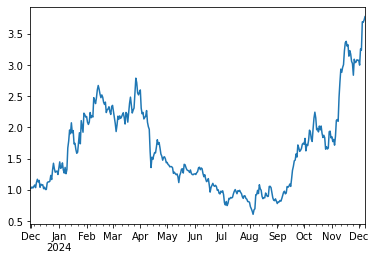

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()